<a href="https://colab.research.google.com/github/Mystour/circuit-tracer/blob/main/demos/circuit_tracing_tutorial_qwen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Circuit Tracing Tutorial

<a target="_blank" href="https://colab.research.google.com/github/safety-research/circuit-tracer/blob/main/demos/circuit_tracing_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook serves as a tutorial for the circuit tracing library. The library enables users to explain model behavior by generating Attribution Graphs (introduced in [Circuit Tracing](https://transformer-circuits.pub/2025/attribution-graphs/methods.html)), and validate these explanations with experiments.

If you'd like to generate your own graphs, you can do so on [Neuronpedia](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&pruningThreshold=0.6&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D&densityThreshold=0.99&clerps=%5B%5B%2223_2312237_10%22%2C%22Cities+and+states+names+%28say+Austin%29%22%5D%2C%5B%2218_1808959_10%22%2C%22state+%2F+regional+government%22%5D%5D). You can also do so directly on Colab using this [starter notebook](https://github.com/safety-research/circuit-tracer/blob/main/demos/attribute_demo.ipynb).

In this demo, we'll dive  into a couple of attribution graphs involving Gemma 2 (2B), based on the Multi-Step Reasoning and Multilingual Circuits examples [in the original paper](https://transformer-circuits.pub/2025/attribution-graphs/biology.html). We'll view the graphs, annotated with labeled supernodes, and then perform interventions to verify that the supernodes' labels are indeed correct, and that interventions have the effect we expect.

In [1]:
from google.colab import output
# output.enable_custom_widget_manager()
output.disable_custom_widget_manager()

In [2]:
# from google.colab import output

# # 修复 "Invalid Notebook" 错误
# # 该错误 "the 'state' key is missing from 'metadata.widgets'" 通常是因为 Widget 元数据不完整

# try:
#     # 1. 禁用自定义组件管理器
#     output.disable_custom_widget_manager()

#     print("✅ 已执行修复操作：禁用自定义组件管理器。")
#     print("👉 请现在尝试再次保存到 GitHub。")
#     print("\n💡 如果仍然报错，请执行以下最终方案：")
#     print("   点击顶部菜单栏的 '编辑' (Edit) -> '清除所有输出' (Clear all outputs)，然后再次保存。")

# except Exception as e:
#     print(f"执行时发生错误: {e}")

In [3]:
#@title 2.1 设置 GitHub Token (安全方式)
from google.colab import userdata
import os

try:
    # 从 Colab Secrets 获取 token
    github_token = userdata.get('GITHUB_TOKEN')
    print("✅ GitHub token 已安全加载！")

    # 设置环境变量 (临时)
    os.environ['GITHUB_TOKEN'] = github_token
    os.environ['GIT_ASKPASS'] = 'echo'  # 避免密码提示

except Exception as e:
    print("❌ 获取 GitHub token 失败:")
    print("💡 请按以下步骤设置:")
    print("1. 点击左侧边栏的 '🔑' (Secrets) 图标")
    print("2. 点击 '+ Add secret'")
    print("3. Name: GITHUB_TOKEN")
    print("4. Value: 你的 GitHub Personal Access Token")
    print("5. 点击 'Save'")
    print("6. 重新运行此代码块")
    raise e

✅ GitHub token 已安全加载！


In [4]:
#@title 3.1 配置 Git 用户信息
import os

# 设置 Git 用户信息
username = "陈子昂"  # 替换为你的 GitHub 用户名
email = "a960015420@163.com"   # 替换为你的邮箱

!git config --global user.name "$username"
!git config --global user.email "$email"
print(f"✅ Git 用户已配置: {username} <{email}>")

#@title 3.2 配置 Git 认证助手
# 使用 token 进行认证
!git config --global credential.helper store
!git config --global url."https://${GITHUB_TOKEN}@github.com/".insteadOf "https://github.com/"

print("✅ Git 认证已配置！")

✅ Git 用户已配置: 陈子昂 <a960015420@163.com>
✅ Git 认证已配置！


In [5]:
#@title 4.1 测试访问私有仓库
try:
    # 替换为你的私有仓库 URL
    private_repo = "https://github.com/Mystour/circuit-tracer.git"

    # 克隆私有仓库测试
    !rm -rf private-repo-test
    !git clone "$private_repo" private-repo-test

    if os.path.exists('private-repo-test'):
        print("✅ 成功访问私有仓库！")
        !ls private-repo-test
    else:
        print("❌ 克隆失败，请检查 token 权限")

except Exception as e:
    print(f"❌ 测试失败: {e}")
    print("💡 常见问题解决:")
    print("- 检查 token 是否有 repo 权限")
    print("- 检查仓库 URL 是否正确")
    print("- 检查仓库是否确实存在")

Cloning into 'private-repo-test'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 380 (delta 161), reused 54 (delta 53), pack-reused 138 (from 2)
Receiving objects: 100% (380/380), 2.29 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (195/195), done.
✅ 成功访问私有仓库！
circuit_tracer	 demos	  pyproject.toml  tests
CONTRIBUTING.md  LICENSE  README.md


In [6]:
#@title Colab Setup Environment

try:
    import google.colab
    !mkdir -p repository && cd repository && \
     git clone https://github.com/safety-research/circuit-tracer && \
     curl -LsSf https://astral.sh/uv/install.sh | sh && \
     uv pip install -e circuit-tracer/

    import sys
    from huggingface_hub import notebook_login
    sys.path.append('repository/circuit-tracer')
    sys.path.append('repository/circuit-tracer/demos')
    notebook_login(new_session=False)
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

fatal: destination path 'circuit-tracer' already exists and is not an empty directory.


In [7]:
from collections import namedtuple
from typing import List, Dict

import torch

from circuit_tracer import ReplacementModel
from circuit_tracer.utils.decode_url_features import decode_url_features

# model = ReplacementModel.from_pretrained("google/gemma-2-2b", 'gemma', dtype=torch.bfloat16)

# 替换为 Qwen 2.5 模型 (例如 1.5B 版本，适合 Colab 显存)
# 对应的架构别名通常为 'qwen2' (取决于 TransformerLens 的支持)
model = ReplacementModel.from_pretrained("Qwen/Qwen2.5-1.5B", 'qwen2', dtype=torch.bfloat16)

config.yaml: 0.00B [00:00, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

layer_3/width_16k/average_l0_54/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_0/width_16k/average_l0_76/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_6/width_16k/average_l0_95/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_5/width_16k/average_l0_87/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_4/width_16k/average_l0_88/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_1/width_16k/average_l0_65/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_2/width_16k/average_l0_49/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_7/width_16k/average_l0_70/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_8/width_16k/average_l0_52/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_9/width_16k/average_l0_72/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_10/width_16k/average_l0_88/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_11/width_16k/average_l0_5/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_13/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_12/width_16k/average_l0_6/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_14/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_15/width_16k/average_l0_8/params.n(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_16/width_16k/average_l0_10/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_17/width_16k/average_l0_12/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_18/width_16k/average_l0_13/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_19/width_16k/average_l0_12/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_20/width_16k/average_l0_11/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_21/width_16k/average_l0_13/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_22/width_16k/average_l0_15/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_23/width_16k/average_l0_25/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_24/width_16k/average_l0_37/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

layer_25/width_16k/average_l0_41/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


# Two-hop reasoning
We'll start with the example [`Fact: The capital of the state containing Dallas is` → `Austin`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&pruningThreshold=0.6&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D&densityThreshold=0.99&clerps=%5B%5B%2223_2312237_10%22%2C%22Cities+and+states+names+%28say+Austin%29%22%5D%2C%5B%2218_1808959_10%22%2C%22state+%2F+regional+government%22%5D%5D), which requires two hop-reasoning. The model must first reason that the state containing Dallas is Texas; then, it must respond with the capital of Texas, Austin.

[The original paper](https://transformer-circuits.pub/2025/attribution-graphs/biology.html#dives-tracing) showed that Haiku solves the problem using the following circuit, computing the intermediate step of the state containing Dallas: Texas.

<img src="https://raw.githubusercontent.com/safety-research/circuit-tracer/main/demos/img/dallas-austin-haiku.png" width="300" />

Performing attribution on Gemma 2 (2B) shows that it uses [this circuit](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&pruningThreshold=0.6&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D&densityThreshold=0.99&clerps=%5B%5B%2223_2312237_10%22%2C%22Cities+and+states+names+%28say+Austin%29%22%5D%2C%5B%2218_1808959_10%22%2C%22state+%2F+regional+government%22%5D%5D) to successfully complete the prompt:

<img src="https://raw.githubusercontent.com/safety-research/circuit-tracer/main/demos/img/gemma/dallas-austin-new.png" width="600" />

The circuit is similar: it has a node corresponding to Texas, and shows both a direct path from Dallas to Austin as well as an indirect path going through Texas. The Attribution Graph suggests a hypothesis about model behavior, based on using transcoders to approximate the behavior of MLPs. We can verify that our understanding of model behavior is correct by performing interventions directly on the underlying model.

We'll perform interventions on each of the supernodes shown. So, we will first get the supernodes from this graph. We have a convenience function that will map a circuit URL (and the supernodes stored therein), to a list of Feature objects; each Feature is a tuple of `(layer, position, feature_index)`.

In [8]:
dallas_austin_url="https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-dallas-austin&clerps=%5B%5D&pruningThreshold=0.53&pinnedIds=27_22605_10%2C20_15589_10%2CE_26865_9%2C21_5943_10%2C23_12237_10%2C20_15589_9%2C16_25_9%2C14_2268_9%2C18_8959_10%2C4_13154_9%2C7_6861_9%2C19_1445_10%2CE_2329_7%2CE_6037_4%2C0_13727_7%2C6_4012_7%2C17_7178_10%2C15_4494_4%2C6_4662_4%2C4_7671_4%2C3_13984_4%2C1_1000_4%2C19_7477_9%2C18_6101_10%2C16_4298_10%2C7_691_10&supernodes=%5B%5B%22capital%22%2C%2215_4494_4%22%2C%226_4662_4%22%2C%224_7671_4%22%2C%223_13984_4%22%2C%221_1000_4%22%5D%2C%5B%22state%22%2C%226_4012_7%22%2C%220_13727_7%22%5D%2C%5B%22Texas%22%2C%2220_15589_9%22%2C%2219_7477_9%22%2C%2216_25_9%22%2C%224_13154_9%22%2C%2214_2268_9%22%2C%227_6861_9%22%5D%2C%5B%22preposition+followed+by+place+name%22%2C%2219_1445_10%22%2C%2218_6101_10%22%5D%2C%5B%22capital+cities+%2F+say+a+capital+city%22%2C%2221_5943_10%22%2C%2217_7178_10%22%2C%227_691_10%22%2C%2216_4298_10%22%5D%5D"
supernode_features, _ = decode_url_features(dallas_austin_url)

We'll then create a representation of the circuit being used to solve this task. This means defining some Supernode objects, which will store a list of underlying features, as well as their children supernodes that they have a causal effect on.

In [9]:
from graph_visualization import create_graph_visualization, Supernode, InterventionGraph, Feature

# Supernodes that upweight certain outputs. Note that e.g. the Say Austin node is not the only node promoting Austin, but that is its primary role
say_austin_node = Supernode(name='Say Austin', features=[Feature(layer=23, pos=10, feature_idx=12237)])
say_capital_node = Supernode(name='Say a capital', features=supernode_features['capital cities / say a capital city'], children=[say_austin_node])

# Intermediate nodes
texas_node = Supernode(name='Texas', features=supernode_features['Texas'], children=[say_austin_node])
state_node = Supernode(name='state', features=supernode_features['state'], children=[say_capital_node, texas_node])
capital_node = Supernode(name='capital', features=supernode_features['capital'], children=[say_capital_node])

# Embedding nodes
dallas_node = Supernode(name='Emb: Dallas', features=None, children=[texas_node])
state_emb_node = Supernode(name='Emb: state', features=None, children=[state_node])
capital_emb_node = Supernode(name='Emb: capital', features=None, children=[capital_node])

We then initialize an InterventionGraph, which stores all of our Supernodes, and keeps track of their state. We'll also get the model's logits and activations on this prompt. We then set each node's default activation (its activation on the original prompt, without interventions), and set its activation fraction. The activation fraction is the node's current activation / its default activation. Since the current and default activations are the same, each node is at 100%

In [10]:
prompt = "Fact: the capital of the state containing Dallas is"
ordered_nodes = [[capital_emb_node, state_emb_node],[capital_node, state_node, dallas_node],[say_capital_node, texas_node], [say_austin_node]]
dallas_austin_graph = InterventionGraph(ordered_nodes=ordered_nodes, prompt=prompt)

logits, dallas_activations = model.get_activations(prompt)

# initialize each node, adding it to the intervention graph and recording its default activation
for node in [capital_node, state_node, dallas_node, say_capital_node, texas_node, say_austin_node]:
    dallas_austin_graph.initialize_node(node, dallas_activations)

# set each node's current activation to a percent of its default activation (here 100%)
dallas_austin_graph.set_node_activation_fractions(dallas_activations)

We'll record the top-5 logits as well, and then visualize our graph!

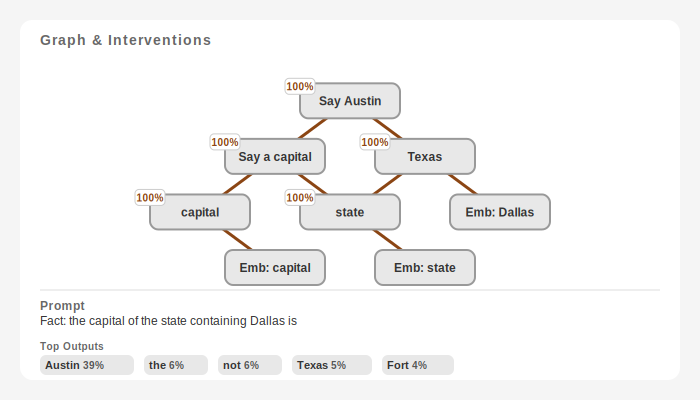

In [11]:
def get_top_outputs(logits: torch.Tensor, k: int = 5):
    top_probs, top_token_ids = logits.squeeze(0)[-1].softmax(-1).topk(k)
    top_tokens = [model.tokenizer.decode(token_id) for token_id in top_token_ids]
    top_outputs = list(zip(top_tokens, top_probs.tolist()))
    return top_outputs

top_outputs = get_top_outputs(logits)

create_graph_visualization(dallas_austin_graph, top_outputs)

The displayed circuit is consistent with the supernodes we created when visualizing the full graph. We'll now verify that each supernode plays the role we hypothesized using interventions. Each intervention will set a node's value to some multiple of its original value.

In [12]:
# An Intervention says "set the activation of supernode to intervention_value * its activation in the given activations tensor"
Intervention = namedtuple('Intervention', ['supernode', 'scaling_factor'])
def supernode_intervention(intervention_graph: InterventionGraph, interventions: List[Intervention], replacements: Dict[str, Supernode] = None):
    """Performs interventions on a set of supernodes, records the outputs, and draws the corresponding graph

    Args:
        interventions (List[Intervention]): List of interventions to perform
        replacements (Dict[str, Supernode], optional): Replacement supernodes to add, if we're adding supernodes
            from another prompt. Defaults to None.

    Returns:
        HTML: An IPython.display.HTML object showing the graph corresponding to these interventions
    """
    intervention_values = [(*feature, scaling_factor * default_act) for intervened_supernode, scaling_factor in interventions
                           for feature, default_act in zip(intervened_supernode.features, intervened_supernode.default_activations)]
    new_logits, new_activations = model.feature_intervention(intervention_graph.prompt, intervention_values)
    intervention_graph.set_node_activation_fractions(new_activations)
    top_outputs = get_top_outputs(new_logits)

    for intervened_supernode, scaling_factor in interventions:
        intervened_supernode.activation = None
        intervened_supernode.intervention = f'{scaling_factor}x'

    if replacements is not None:
        for target, replacement in replacements.items():
            intervention_graph.nodes[target].replacement_node = replacement

    return create_graph_visualization(intervention_graph, top_outputs)

In the original paper, turning off the "Say a capital" feature caused the "Say Austin" supernode to shut off, and the model's top logit to change to Texas. What happens if we do the same?

In [13]:
supernode_intervention(dallas_austin_graph, [Intervention(say_capital_node, -2)])

KeyboardInterrupt: 

We observe precisely the same behavior! Strongly shutting off the "Say a capital" supernode turned off the "Say Austin" node, and changed the top logit to Texas.

What if we turn off the "capital" supernode?

In [ ]:
supernode_intervention(dallas_austin_graph, [Intervention(capital_node, -2)])

This yields similar behavior to before. We turn off the "Say a capital" supernode, though not as strongly in as in the prior intervention. This also partially turns off the "Say Austin" node.

What if we turn off the Texas supernode?

In [ ]:
supernode_intervention(dallas_austin_graph, [Intervention(texas_node, -2)])

Turning the Texas supernode off also disabled the "Say Austin" node, yielding the capitals of other states.

What if we turn off the "state" supernode?

In [ ]:
supernode_intervention(dallas_austin_graph, [Intervention(state_node, -2)])

Turning off the state supernode was largely ineffective: it caused little change to any of the other supernode activations, and little change to the model logits.

We’ve validated the behavior of nodes by ablating them. Could we inject entirely different nodes and validate that they have the expected effect? Take the circuit from the prompt [`Fact: The capital of the state containing Oakland is` → `Sacramento`]((https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-oakland-sacramento&pruningThreshold=0.5&pinnedIds=27_43939_10%2CE_49024_9%2C21_5943_10%2C19_9209_10%2C18_8959_10%2C14_12562_9%2C7_14530_9%2C8_14641_9%2C4_8625_9%2C19_9209_9%2C17_7178_10%2CE_6037_4%2C15_4494_4%2CE_2329_7%2C16_4298_10%2C7_691_10%2C6_4662_4%2C4_7671_4%2C2_8734_4%2C0_1961_4%2C6_13909_9%2C22_4367_10%2C21_2464_10&supernodes=%5B%5B%22capital%22%2C%226_4662_4%22%2C%2215_4494_4%22%2C%224_7671_4%22%2C%222_8734_4%22%2C%220_1961_4%22%5D%2C%5B%22capital%22%2C%2221_5943_10%22%2C%2216_4298_10%22%2C%2217_7178_10%22%2C%227_691_10%22%5D%2C%5B%22California%22%2C%2222_4367_10%22%2C%2221_2464_10%22%5D%2C%5B%22California%22%2C%226_13909_9%22%2C%228_14641_9%22%2C%2214_12562_9%22%5D%2C%5B%22Bay+Area+%28say+California%29%22%2C%2219_9209_9%22%2C%227_14530_9%22%2C%224_8625_9%22%5D%5D&clickedId=27_43939_10&densityThreshold=0.99&clerps=%5B%5B%2219_1909209_9%22%2C%22Bay+area%22%5D%2C%5B%2219_1909209_10%22%2C%22Bay+Area%22%5D%5D)). We'll add two supernodes from this graph—"California" and "Say Sacramento" to our InterventionGraph.

In [ ]:
oakland_prompt = "Fact: the capital of the state containing Oakland is"
_, oakland_activations = model.get_activations(oakland_prompt)

oakland_url = "https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-oakland-sacramento&clerps=%5B%5D&pruningThreshold=0.5&pinnedIds=27_43939_10%2CE_49024_9%2C21_5943_10%2C19_9209_10%2C18_8959_10%2C14_12562_9%2C7_14530_9%2C8_14641_9%2C4_8625_9%2C19_9209_9%2C17_7178_10%2CE_6037_4%2C15_4494_4%2CE_2329_7%2C16_4298_10%2C7_691_10%2C6_4662_4%2C4_7671_4%2C2_8734_4%2C0_1961_4%2C6_13909_9%2C22_4367_10%2C21_2464_10&supernodes=%5B%5B%22capital%22%2C%226_4662_4%22%2C%2215_4494_4%22%2C%224_7671_4%22%2C%222_8734_4%22%2C%220_1961_4%22%5D%2C%5B%22capital%22%2C%2221_5943_10%22%2C%2216_4298_10%22%2C%2217_7178_10%22%2C%227_691_10%22%5D%2C%5B%22California%22%2C%2222_4367_10%22%2C%2221_2464_10%22%5D%2C%5B%22Bay+Area+%28say+California%29%22%2C%227_14530_9%22%2C%224_8625_9%22%5D%2C%5B%22California%22%2C%226_13909_9%22%2C%228_14641_9%22%2C%2214_12562_9%22%5D%5D&clickedId=27_43939_10"
oakland_supernodes, _ = decode_url_features(oakland_url)

say_sacramento_node = Supernode('Say Sacramento', features=[Feature(layer=19, pos=10, feature_idx=9209)])
california_node = Supernode('California', features=oakland_supernodes['California'] + oakland_supernodes['California (2)'],
                       children=[say_sacramento_node])

for node in [say_sacramento_node, california_node]:
    dallas_austin_graph.initialize_node(node, oakland_activations)

Then, we'll perform an intervention, turning off the Texas supernode, and turning on the California one.

In [ ]:
oakland_interventions = [Intervention(texas_node, -2), Intervention(california_node, 2)]
supernode_intervention(dallas_austin_graph, oakland_interventions, {texas_node.name: california_node, say_austin_node.name: say_sacramento_node})

Doing this caused the "Say Austin" node to shut off entirely, while the "Say Sacramento" node began to activate! Our model's top output is now Sacramento, as well.

We can also do this replacing states with countries. Take the circuit for [`Fact: The capital of the country containing Shanghai is` → `Beijing`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-shanghai-beijing&clerps=%5B%5D&clickedId=15_4494_4&pruningThreshold=0.45&pinnedIds=27_33395_10%2CE_38628_9%2C21_5943_10%2C19_12274_10%2C19_12274_9%2C14_12274_9%2C18_6101_10%2C17_7178_10%2C6_6811_9%2C4_4257_9%2C4_11570_9%2CE_6037_4%2C0_8885_4%2C18_7639_10%2C19_2695_10%2C16_4298_10%2C15_4494_4%2C6_4662_4&supernodes=%5B%5B%22China%22%2C%2219_12274_9%22%2C%2214_12274_9%22%2C%226_6811_9%22%2C%224_11570_9%22%2C%224_4257_9%22%5D%2C%5B%22China%22%2C%2219_12274_10%22%2C%2218_7639_10%22%5D%2C%5B%22capital%22%2C%2216_4298_10%22%2C%2217_7178_10%22%2C%2218_6101_10%22%2C%2219_2695_10%22%2C%2221_5943_10%22%5D%2C%5B%22capital+cities+%28say+city%29%22%2C%226_4662_4%22%2C%2215_4494_4%22%2C%220_8885_4%22%5D%5D). We'll do precisely what we did before, disabling Texas and activating the China supernode. This time, there is no "Say Beijing" node, but the effect of this intervention should be visible in the logits.

In [ ]:
shanghai_prompt = "Fact: the capital of the country containing Shanghai is"
_, shanghai_activations = model.get_activations(shanghai_prompt)

shanghai_url = "https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-shanghai-beijing&clerps=%5B%5D&clickedId=15_4494_4&pruningThreshold=0.45&pinnedIds=27_33395_10%2CE_38628_9%2C21_5943_10%2C19_12274_10%2C19_12274_9%2C14_12274_9%2C18_6101_10%2C17_7178_10%2C6_6811_9%2C4_4257_9%2C4_11570_9%2CE_6037_4%2C0_8885_4%2C18_7639_10%2C19_2695_10%2C16_4298_10%2C15_4494_4%2C6_4662_4&supernodes=%5B%5B%22China%22%2C%2219_12274_9%22%2C%2214_12274_9%22%2C%226_6811_9%22%2C%224_11570_9%22%2C%224_4257_9%22%5D%2C%5B%22China%22%2C%2219_12274_10%22%2C%2218_7639_10%22%5D%2C%5B%22capital%22%2C%2216_4298_10%22%2C%2217_7178_10%22%2C%2218_6101_10%22%2C%2219_2695_10%22%2C%2221_5943_10%22%5D%2C%5B%22capital+cities+%28say+city%29%22%2C%226_4662_4%22%2C%2215_4494_4%22%2C%220_8885_4%22%5D%5D"
shanghai_supernodes, _ = decode_url_features(shanghai_url)

china_node = Supernode('China', features=shanghai_supernodes['China'] + shanghai_supernodes['China (2)'])#,

for node in [china_node]:
    dallas_austin_graph.initialize_node(node, shanghai_activations)

china_interventions = [Intervention(texas_node, -2), Intervention(china_node, 2)]
supernode_intervention(dallas_austin_graph, china_interventions, {texas_node.name: china_node})

This works as well! Beijing is now the models' most likely output.

Does this always work? Let's try with the circuit for [`Fact: the capital of the territory containing Vancouver is` → `Victoria`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-vancouver-victoria&clickedId=4_11742_9&pruningThreshold=0.45&pinnedIds=27_18221_10%2CE_32936_9%2C21_2236_10%2C19_15123_10%2C18_1025_10%2C14_12562_9%2C14_5600_9%2C6_11873_9%2C4_8439_9%2CE_6037_4%2CE_19412_7%2C4_11742_9%2C0_16137_7&supernodes=%5B%5B%22Canada%22%2C%2214_5600_9%22%2C%226_11873_9%22%2C%224_8439_9%22%5D%5D&densityThreshold=0.99&clerps=%5B%5B%2214_1412562_9%22%2C%22California%22%5D%2C%5B%224_411742_9%22%2C%22Pacific+northwest%22%5D%2C%5B%2221_2102236_10%22%2C%22Victoria%22%5D%2C%5B%2218_1801025_10%22%2C%22British+Columbia%22%5D%5D).

In [ ]:
vancouver_prompt = "Fact: the capital of the territory containing Vancouver is"
_, vancouver_activations = model.get_activations(vancouver_prompt)

vancouver_url = "https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-fact-vancouver-victoria&clerps=%5B%5D&clickedId=4_11742_9&pruningThreshold=0.45&pinnedIds=27_18221_10%2CE_32936_9%2C21_2236_10%2C19_15123_10%2C18_1025_10%2C14_12562_9%2C14_5600_9%2C6_11873_9%2C4_8439_9%2CE_6037_4%2CE_19412_7%2C4_11742_9%2C0_16137_7&supernodes=%5B%5B%22Canada%22%2C%2214_5600_9%22%2C%226_11873_9%22%2C%224_8439_9%22%5D%5D"
vancouver_supernodes, _ = decode_url_features(vancouver_url)

say_victoria_node = Supernode('Say Victoria', features=[Feature(layer=21, pos=10, feature_idx=2236)])
bc_node = Supernode('British Columbia', features=[Feature(layer=18, pos=10, feature_idx=1025)],
                       children=[say_victoria_node])

for node in [say_victoria_node, bc_node]:
    dallas_austin_graph.initialize_node(node, vancouver_activations)

In [ ]:
bc_interventions = [Intervention(texas_node, -2), Intervention(bc_node, 2)]
supernode_intervention(dallas_austin_graph, bc_interventions, {texas_node.name: bc_node, say_austin_node.name: say_victoria_node})

In this case, the intervention was not very effective. The model's output looks like it did when just ablating Texas, which indicates that the addition of British Columbia did little. A motivated reader might want to try activating the British Columbia node more strongly - what happens?

## Multilingual Circuits

In this section, we'll look at multilingual circuits, as studied [in the original paper](https://transformer-circuits.pub/2025/attribution-graphs/biology.html#dives-multilingual). Specifically, we'll look at three circuits, for the same sentence in 3 languages:
- English: [`The opposite of "small" is "` → `big`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-small-big-en&pruningThreshold=0.65&pinnedIds=27_13210_8%2CE_10498_5%2C23_8683_8%2C21_10062_8%2C17_12530_5%2C18_9402_8%2C6_4362_5%2C15_5617_5%2C15_5756_5%2C19_5058_8%2C14_11360_5%2CE_13388_2%2C15_7209_2%2C4_95_2%2C3_6576_2%2C27_7773_8%2C7_10545_5&supernodes=%5B%5B%22Output+%5C%22big%5C%22+or+%5C%22large%5C%22%22%2C%2227_7773_8%22%2C%2227_13210_8%22%5D%2C%5B%22say+big+%2F+huge+%2F+large%22%2C%2221_10062_8%22%2C%2223_8683_8%22%5D%2C%5B%22opposite%22%2C%224_95_2%22%2C%2215_7209_2%22%2C%223_6576_2%22%5D%2C%5B%22small%22%2C%2214_11360_5%22%2C%2217_12530_5%22%2C%2215_5617_5%22%5D%2C%5B%22large+%2F+size%22%2C%226_4362_5%22%2C%227_10545_5%22%2C%2215_5756_5%22%5D%5D&clickedId=6_4362_5&densityThreshold=0.99&clerps=%5B%5B%2219_1905058_8%22%2C%22comparatives%22%5D%5D)
- French: [`Le contraire de "petit" est "` → `grand`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-small-big-fr&pruningThreshold=0.65&pinnedIds=27_21996_8%2CE_64986_5%2C24_16045_8%2C19_5058_8%2C21_10062_8%2C23_2592_8%2C20_1454_8%2CE_63265_2%2C23_8683_8%2C23_8488_8%2C20_11434_8%2C19_5802_8%2CE_1455_7%2C15_5617_5%2C18_9402_8%2C6_4362_5%2C14_11360_5%2C3_2908_5%2C2_5452_5%2C3_6627_5%2C6_16184_2%2C4_95_2%2C22_10566_8%2C21_1144_8%2CE_2025_1%2CE_581_3&supernodes=%5B%5B%22opposite%22%2C%226_16184_2%22%2C%224_95_2%22%5D%2C%5B%22say+big+%2F+large%22%2C%2223_8683_8%22%2C%2223_8488_8%22%2C%2221_10062_8%22%5D%2C%5B%22comparatives%22%2C%2219_5058_8%22%2C%2224_16045_8%22%2C%2220_11434_8%22%5D%2C%5B%22small%22%2C%2215_5617_5%22%2C%2214_11360_5%22%2C%223_6627_5%22%2C%223_2908_5%22%2C%222_5452_5%22%5D%2C%5B%22size%22%2C%2218_9402_8%22%2C%226_4362_5%22%5D%2C%5B%22French%22%2C%2221_1144_8%22%2C%2222_10566_8%22%2C%2220_1454_8%22%2C%2223_2592_8%22%2C%2219_5802_8%22%5D%5D&clickedId=22_10566_8&densityThreshold=0.99)
- Chinese: [`"小"的反义词是"` → `大`](http://neuronpedia.org/gemma-2-2b/graph?slug=gemma-small-big-zh&pruningThreshold=0.65&pinnedIds=27_235469_8%2CE_235585_2%2C23_8488_8%2C23_8683_8%2C21_10062_8%2C19_5058_8%2C22_11933_8%2C21_9377_8%2C18_9402_8%2C15_5617_2%2C14_11360_2%2C14_13476_2%2C2_2169_2%2C1_10169_2%2C8_1988_6%2C4_15846_6%2C4_7409_6%2CE_208659_4%2CE_237379_6%2CE_236711_5%2C24_2394_8%2C23_13630_8%2C21_13505_8%2C20_12983_8&supernodes=%5B%5B%22reverse%22%2C%224_7409_6%22%2C%228_1988_6%22%2C%224_15846_6%22%5D%2C%5B%22small%22%2C%2215_5617_2%22%2C%2214_11360_2%22%5D%2C%5B%22say+big+%2F+large%22%2C%2223_8683_8%22%2C%2221_10062_8%22%2C%2223_8488_8%22%5D%2C%5B%22Chinese%22%2C%2224_2394_8%22%2C%2222_11933_8%22%2C%2220_12983_8%22%2C%2221_13505_8%22%2C%2223_13630_8%22%5D%2C%5B%22Chinese-related+English+text%22%2C%221_10169_2%22%2C%2214_13476_2%22%5D%2C%5B%22size%22%2C%2218_9402_8%22%2C%222_2169_2%22%5D%2C%5B%22comparatives%22%2C%2221_9377_8%22%2C%2219_5058_8%22%5D%5D&clickedId=27_235469_8&densityThreshold=0.99)

Work on Haiku showed one shared multilingual circuit:

<img src="https://raw.githubusercontent.com/safety-research/circuit-tracer/main/demos/img/multilingual-haiku.png" width="900" />

Our circuits indicate the same behavior. In fact, unlike the Haiku circuits, the Gemma 2 (2B) circuits are essentially entirely multilingual. There are no individual "Say big" or "Say grand" supernodes that cause the model to output a specific answer in a specific language. Instead, all circuits use "Say big" features, combined with a "French" or "Chinese" feature if the answer is non-English.

Let's study these circuits by performing interventions on them. First, we'll create Supernode objects, as before:

In [ ]:
url_fr = 'https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-small-big-fr&clerps=%5B%5D&pruningThreshold=0.65&pinnedIds=27_21996_8%2CE_64986_5%2C24_16045_8%2C19_5058_8%2C21_10062_8%2C23_2592_8%2C20_1454_8%2CE_63265_2%2C23_8683_8%2C23_8488_8%2C20_11434_8%2C19_5802_8%2CE_1455_7%2C15_5617_5%2C18_9402_8%2C6_4362_5%2C14_11360_5%2C3_2908_5%2C2_5452_5%2C3_6627_5%2C6_16184_2%2C4_95_2%2C22_10566_8%2C21_1144_8%2CE_2025_1%2CE_581_3%2C5_982_2%2C6_651_2%2C5_8646_2%2C6_2743_2%2C8_1988_2%2C4_7409_2%2C4_15846_2%2C3_11241_2%2C2_321_2%2C2_4657_2&supernodes=%5B%5B%22say+big+%2F+large%22%2C%2223_8683_8%22%2C%2223_8488_8%22%2C%2221_10062_8%22%5D%2C%5B%22too%22%2C%2219_5058_8%22%2C%2224_16045_8%22%2C%2220_11434_8%22%5D%2C%5B%22small%22%2C%2215_5617_5%22%2C%2214_11360_5%22%2C%223_6627_5%22%2C%223_2908_5%22%2C%222_5452_5%22%5D%2C%5B%22size%22%2C%2218_9402_8%22%2C%226_4362_5%22%5D%2C%5B%22French%22%2C%2221_1144_8%22%2C%2222_10566_8%22%2C%2220_1454_8%22%2C%2223_2592_8%22%2C%2219_5802_8%22%5D%2C%5B%22opposite%22%2C%226_16184_2%22%2C%224_95_2%22%2C%225_8646_2%22%2C%226_2743_2%22%2C%228_1988_2%22%2C%226_651_2%22%2C%225_982_2%22%2C%222_321_2%22%2C%223_11241_2%22%2C%222_4657_2%22%2C%224_7409_2%22%2C%224_15846_2%22%5D%5D&clickedId=3_11241_2'
supernodes_fr, _ = decode_url_features(url_fr)
french_node = Supernode('French', features=supernodes_fr['French'], children=[])
say_big_node = Supernode('Say big', features=supernodes_fr["say big / large"])
small_node = Supernode('small', features=supernodes_fr['small'], children=[say_big_node])
opposite_node = Supernode('opposite', features=supernodes_fr['opposite'], children=[say_big_node])

url_en = 'https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-small-big-en&clerps=%5B%5D&pruningThreshold=0.65&pinnedIds=27_13210_8%2CE_10498_5%2C23_8683_8%2C21_10062_8%2C17_12530_5%2C18_9402_8%2C6_4362_5%2C15_5617_5%2C15_5756_5%2C19_5058_8%2C14_11360_5%2CE_13388_2%2C15_7209_2%2C4_95_2%2C3_6576_2%2C27_7773_8%2C7_10545_5&supernodes=%5B%5B%22Output+%5C%22big%5C%22+or+%5C%22large%5C%22%22%2C%2227_7773_8%22%2C%2227_13210_8%22%5D%2C%5B%22say+big+%2F+huge+%2F+large%22%2C%2221_10062_8%22%2C%2223_8683_8%22%5D%2C%5B%22opposite%22%2C%224_95_2%22%2C%2215_7209_2%22%2C%223_6576_2%22%5D%2C%5B%22small%22%2C%2214_11360_5%22%2C%2217_12530_5%22%2C%2215_5617_5%22%5D%2C%5B%22large+%2F+size%22%2C%226_4362_5%22%2C%227_10545_5%22%2C%2215_5756_5%22%5D%5D&clickedId=6_4362_5'
supernodes_en, _ = decode_url_features(url_en)


url_zh = 'https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-small-big-zh&clerps=%5B%5D&pruningThreshold=0.65&pinnedIds=27_235469_8%2CE_235585_2%2C23_8488_8%2C23_8683_8%2C21_10062_8%2C19_5058_8%2C22_11933_8%2C21_9377_8%2C18_9402_8%2C15_5617_2%2C14_11360_2%2C14_13476_2%2C2_2169_2%2C1_10169_2%2C8_1988_6%2C4_15846_6%2C4_7409_6%2CE_208659_4%2CE_237379_6%2CE_236711_5%2C24_2394_8%2C23_13630_8%2C21_13505_8%2C20_12983_8&supernodes=%5B%5B%22reverse%22%2C%224_7409_6%22%2C%228_1988_6%22%2C%224_15846_6%22%5D%2C%5B%22small%22%2C%2215_5617_2%22%2C%2214_11360_2%22%5D%2C%5B%22say+big+%2F+large%22%2C%2223_8683_8%22%2C%2221_10062_8%22%2C%2223_8488_8%22%5D%2C%5B%22Chinese%22%2C%2224_2394_8%22%2C%2222_11933_8%22%2C%2220_12983_8%22%2C%2221_13505_8%22%2C%2223_13630_8%22%5D%2C%5B%22Chinese-related+English+text%22%2C%221_10169_2%22%2C%2214_13476_2%22%5D%2C%5B%22size%22%2C%2218_9402_8%22%2C%222_2169_2%22%5D%5D&clickedId=27_235469_8'
supernodes_zh, _ = decode_url_features(url_zh)
chinese_node = Supernode('Chinese', features=supernodes_zh['Chinese'] + supernodes_zh['Chinese-related English text'], children=[])

ordered_nodes_fr = [[french_node, opposite_node, small_node], [say_big_node]]

prompt_en = 'The opposite of "small" is "'
prompt_fr = 'Le contraire de "petit" est "'
prompt_zh = '"小"的反义词是"'

small_big_graph = InterventionGraph(ordered_nodes=ordered_nodes_fr, prompt=prompt_fr)

Then, we get the activations for these nodes, initialize them, and create a visualization.

In [ ]:
logits_fr, activations_fr = model.get_activations(prompt_fr)

for node in [say_big_node, small_node, french_node, opposite_node]:
    small_big_graph.initialize_node(node, activations_fr)  # initialize each node, adding it to the graph and recording its default activation

logits_zh, activations_zh = model.get_activations(prompt_zh)
small_big_graph.initialize_node(chinese_node, activations_zh)

small_big_graph.set_node_activation_fractions(activations_fr)  # set each node's current activation to a percent of its default activation (here always 100%)
create_graph_visualization(small_big_graph, get_top_outputs(logits_fr))

Great! Now let's perform our first intervention: we'll turn off the French supernode.

In [ ]:
french_to_english_interventions = [Intervention(french_node, -2)]
supernode_intervention(small_big_graph, french_to_english_interventions)

Turning off the French supernode resulted in English output! Notably, it had only minor effects on the "Say big" supernode; their effects seem to be independent.

Now, let's try to change the language to another: we'll turn off the French supernode, and turn on the Chinese supernode.

In [ ]:
french_to_chinese_interventions = [Intervention(french_node, -2), Intervention(chinese_node, 2)]
supernode_intervention(small_big_graph, french_to_chinese_interventions, replacements={french_node.name: chinese_node})

As expected, the model's output post-intervention is identical to its original output on the Chinese example.

What if we replace the "small" feature with a "big" feature?

In [ ]:
url_fr_big_small = 'https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-big-small-fr&clerps=%5B%5D&pruningThreshold=0.65&clickedId=21_9082_8&pinnedIds=27_64986_8%2CE_21996_5%2C21_9082_8%2C15_5756_5%2C6_4362_5%2C3_2873_5%2C2_4298_5&supernodes=%5B%5B%22large+%2F+huge%22%2C%2215_5756_5%22%2C%226_4362_5%22%2C%223_2873_5%22%2C%222_4298_5%22%5D%5D'
supernodes_fr_big_small, _ = decode_url_features(url_fr_big_small)
say_small_node = Supernode('Say small', features=[Feature(layer=21, pos=8, feature_idx=9082)])
big_node = Supernode('big', features=supernodes_fr_big_small['large / huge'], children=[say_small_node])

prompt_fr_rev = 'Le contraire de "grand" est "'
logits_fr_rev, activations_fr_rev = model.get_activations(prompt_fr_rev)

for node in [say_small_node, big_node]:
    small_big_graph.initialize_node(node, activations_fr_rev)  # initialize each node, adding it to the graph and recording its default activation

big_to_small_interventions = [Intervention(small_node, -2), Intervention(big_node, 2)]
supernode_intervention(small_big_graph, big_to_small_interventions, replacements={small_node.name: big_node, say_big_node.name: say_small_node})

Replacing the "small" supernode with a "big" supernode causes the "Say big" supernode to shut off, and a new "Say small" supernode to turn on! The model's output changes to "petit", or "small", in French.

We'll try one last intervention - can we replace the "opposite" supernode with a "synonym" supernode, to obtain a synonymous output? Our model is not very good at synonymy; given 'Un synonyme de "petit" est "', it repeats "petit", rather than another synonym. But we can still see if this intervention reproduces that behavior.

In [ ]:
url_fr_syn = 'https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-small-min-fr&clerps=%5B%5D&pruningThreshold=0.8&pinnedIds=27_64986_9%2C27_69658_9%2CE_64986_6%2C8_11850_3%2CE_14904_2%2C4_13762_3%2C6_10175_3%2C3_15891_3&supernodes=%5B%5B%22synonymy%22%2C%223_15891_3%22%2C%228_11850_3%22%2C%224_13762_3%22%2C%226_10175_3%22%5D%5D&clickedId=5_13985_3'
supernodes_fr_syn, _ = decode_url_features(url_fr_syn)
say_small_node2 = Supernode('say small', features=[Feature(layer=21, pos=8, feature_idx=9082)])
synonym_node = Supernode('synonym', features=supernodes_fr_syn['synonymy'], children=[say_small_node2])

prompt_fr_syn = 'Un synonyme de "petit" est "'
logits_fr_syn, activations_fr_syn = model.get_activations(prompt_fr_syn)
print('Top outputs for Un synonyme de "petit" est ": ', get_top_outputs(logits_fr_syn))

small_big_graph.initialize_node(synonym_node, activations_fr_syn)  # initialize each node, adding it to the graph and recording its default activation
synonym_node.features = [Feature(layer=f.layer, pos=f.pos-1, feature_idx=f.feature_idx) for f in synonym_node.features]

antonym_to_synonym_interventions = [Intervention(opposite_node, -2), Intervention(synonym_node, 2)]
supernode_intervention(small_big_graph, antonym_to_synonym_interventions, replacements={opposite_node.name: synonym_node, say_big_node.name: say_small_node})

Unfortunately, this intervention doesn't work! Though the "Say small" supernode turns on, the "Say big" supernode stays on too, and the model's outputs don't change. This is not very surprising - if we look at the original [circuit](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-small-big-fr&clerps=%5B%5D&pruningThreshold=0.65&pinnedIds=27_21996_8%2CE_64986_5%2C24_16045_8%2C19_5058_8%2C21_10062_8%2C23_2592_8%2C20_1454_8%2CE_63265_2%2C23_8683_8%2C23_8488_8%2C20_11434_8%2C19_5802_8%2CE_1455_7%2C15_5617_5%2C18_9402_8%2C6_4362_5%2C14_11360_5%2C3_2908_5%2C2_5452_5%2C3_6627_5%2C6_16184_2%2C4_95_2%2C22_10566_8%2C21_1144_8%2CE_2025_1%2CE_581_3&supernodes=%5B%5B%22opposite%22%2C%226_16184_2%22%2C%224_95_2%22%5D%2C%5B%22say+big+%2F+large%22%2C%2223_8683_8%22%2C%2223_8488_8%22%2C%2221_10062_8%22%5D%2C%5B%22too%22%2C%2219_5058_8%22%2C%2224_16045_8%22%2C%2220_11434_8%22%5D%2C%5B%22small%22%2C%2215_5617_5%22%2C%2214_11360_5%22%2C%223_6627_5%22%2C%223_2908_5%22%2C%222_5452_5%22%5D%2C%5B%22size%22%2C%2218_9402_8%22%2C%226_4362_5%22%5D%2C%5B%22French%22%2C%2221_1144_8%22%2C%2222_10566_8%22%2C%2220_1454_8%22%2C%2223_2592_8%22%2C%2219_5802_8%22%5D%5D&clickedId=22_10566_8) for the task, we see that the "opposite" supernode has only weak connections to the output. As a result, its causal effect is rather low, even though it would make sense for it to play a role.

## Other Notebooks and (Un)Labeled Circuits

Want to learn more? Check out the following other notebooks in the `demos` folder:
These how to use our library:
- `demos/attribute_demo.ipynb`: Demonstrates how to find circuits and visualize them.
- `demos/intervention_demo.ipynb`: Demonstrates how to perform interventions on models.

These dig deeper into specific, pre-computed and pre-annotated attribution graphs, performing interventions to demonstrate the correctness of the annotated graph:
- `demos/gemma_demo.ipynb`: Explores graphs from Gemma 2 (2B)
- `demos/gemma_it_demo.ipynb`: Explores graphs from instruction-tuned Gemma 2 (2B), using transcoders from the base model.
- `demos/llama_demo.ipynb`: Explores graphs from Llama 3.2 (1B)

You can also explore some more labeled examples:
- [`The girls that the teacher sees` → `are`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-girls-are&pinnedIds=27_708_6%2C25_9974_6%2C22_11517_6%2CE_8216_2%2CE_674_3%2CE_651_1%2C19_1880_6%2C15_13979_6%2C17_7377_6%2C18_703_6%2C16_3689_6%2C15_4906_6%2C15_233_6%2CE_17733_6%2C3_6616_6%2C6_11265_6%2C5_1034_6%2C4_2671_6%2C3_6243_4%2C3_9864_3%2C0_13503_3&clickedId=3_9864_3&supernodes=%5B%5B%22see%2Fsaw%22%2C%2215_233_6%22%2C%226_11265_6%22%2C%223_6616_6%22%5D%2C%5B%22ends+of+noun+phrases+%28predict+a+verb%29%22%2C%2219_1880_6%22%2C%2217_7377_6%22%5D%2C%5B%22verbs+ending+relative+clauses%22%2C%224_2671_6%22%2C%2215_4906_6%22%2C%2215_13979_6%22%2C%2218_703_6%22%5D%2C%5B%22that%22%2C%220_13503_3%22%2C%223_9864_3%22%5D%5D&pruningThreshold=0.7&densityThreshold=0.99&clerps=%5B%5B%2225_2509974_6%22%2C%22say+are%22%5D%2C%5B%225_501034_6%22%2C%22transitive+verbs+with+objects+preceding+htem%22%5D%5D)
- [`The International Advanced Security Group (IAS` → `G`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-G&pinnedIds=25_5604_7%2C24_763_7%2C22_12304_7%2C23_14585_7%2C24_1668_7%2C20_7544_7%2C17_4855_5%2C24_9503_7%2C17_4886_5%2C14_1031_5%2C13_7451_5%2C4_3134_5%2CE_5897_5%2C1_3977_5%2C13_5661_7%2C11_10532_7%2C11_7419_7%2C10_4451_7%2C6_9719_7%2CE_24632_7%2CE_591_6%2C0_548_7%2C2_12787_7%2C2_12811_7%2C2_4716_7%2C2_8870_7%2C5_10381_7%2C6_3358_7%2C7_7303_7%2C7_4807_7%2C7_15088_7%2C8_4119_7%2C10_2379_7%2C9_15938_7%2C10_8308_7%2C10_11210_7%2C14_922_7%2C15_5076_7%2C14_15510_7%2C15_444_7%2C17_14853_7%2C27_235319_7%2C2_8493_5%2C3_4791_6%2C4_6672_6%2C5_12154_6%2C5_112_6%2C8_15626_7%2C13_945_6%2C9_13890_6%2C5_12910_7%2C14_1031_6%2C14_13599_6%2C21_5066_6%2C13_13476_6%2C16_3033_6%2C25_4062_7%2C15_1301_6%2C6_11788_7%2C7_12830_7%2C11_8369_6%2C0_14394_7%2C0_7197_7%2C0_4370_7%2C0_3410_7%2C0_5548_7%2C0_13190_7%2C0_2592_7%2C1_10188_7%2C15_12642_5%2C23_999_7%2C14_13969_5%2C21_1146_7%2C24_2871_7%2C25_5880_7%2C24_7620_7%2C23_12120_7%2C25_10087_7&supernodes=%5B%5B%22Activates+on+%28+before+acronym+%2F+upweights+G*%22%2C%2220_7544_7%22%2C%2222_12304_7%22%5D%2C%5B%22%5C%22group%5C%22%22%2C%221_3977_5%22%2C%222_8493_5%22%2C%2217_4855_5%22%5D%2C%5B%22Activates+on+%28+before+acronym%22%2C%2221_5066_6%22%2C%2211_8369_6%22%2C%2213_945_6%22%2C%229_13890_6%22%2C%2214_13599_6%22%2C%2215_1301_6%22%2C%2216_3033_6%22%2C%2213_13476_6%22%2C%225_112_6%22%2C%225_12154_6%22%2C%224_6672_6%22%2C%223_4791_6%22%5D%2C%5B%22Predict+tokens+starting+with+G%22%2C%2223_999_7%22%2C%2224_1668_7%22%2C%2225_5604_7%22%5D%2C%5B%22Tokens+in+acronymable+proper+nouns%22%2C%2213_7451_5%22%2C%2214_13969_5%22%5D%2C%5B%22tokens+followed+by+G%22%2C%2221_1146_7%22%2C%2224_2871_7%22%2C%2225_5880_7%22%2C%2224_7620_7%22%5D%2C%5B%22all+caps%22%2C%2225_10087_7%22%2C%2223_12120_7%22%2C%2223_14585_7%22%2C%2224_763_7%22%5D%2C%5B%22Tokens+starting+with+G%22%2C%2214_1031_6%22%2C%2215_12642_5%22%2C%2214_1031_5%22%2C%224_3134_5%22%2C%2217_4886_5%22%5D%2C%5B%22first+token+of+acronyms%22%2C%220_7197_7%22%2C%220_5548_7%22%2C%220_3410_7%22%2C%220_4370_7%22%2C%222_8870_7%22%2C%220_13190_7%22%2C%220_14394_7%22%2C%220_2592_7%22%2C%221_10188_7%22%2C%227_12830_7%22%2C%2213_5661_7%22%2C%2214_922_7%22%2C%2217_14853_7%22%2C%227_15088_7%22%2C%229_15938_7%22%2C%2210_8308_7%22%2C%2215_5076_7%22%2C%2210_11210_7%22%2C%2211_10532_7%22%2C%226_9719_7%22%2C%225_10381_7%22%2C%222_12811_7%22%2C%222_4716_7%22%5D%2C%5B%22tokens+of+acronyms+in+parentheses%22%2C%2215_444_7%22%2C%228_4119_7%22%2C%2210_2379_7%22%2C%226_3358_7%22%2C%225_12910_7%22%2C%2224_9503_7%22%2C%226_11788_7%22%2C%2225_4062_7%22%2C%220_548_7%22%2C%2211_7419_7%22%2C%2210_4451_7%22%2C%2214_15510_7%22%2C%227_7303_7%22%2C%227_4807_7%22%2C%222_12787_7%22%2C%228_15626_7%22%5D%5D&clickedId=24_13541_7&pruningThreshold=0.7&densityThreshold=0.99)
- [`The guitarist knew the song` → `. / is`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-gp-nps&clerps=%5B%5B%222413277%22%2C%22%28incomprehensible%29%22%5D%2C%5B%222106697%22%2C%22The+X+at+start+of+sentence+%28subject+NPs%29%22%5D%2C%5B%222012754%22%2C%22ends+of+NPs%2C+upweights+verbs%22%5D%2C%5B%222305096%22%2C%22ends+of+phrases+%22%5D%2C%5B%222001993%22%2C%22say+%5C%22would%5C%22%22%5D%2C%5B%222111913%22%2C%22subject+in+sentential+clause+%28say+%5C%22had%5C%22%29%22%5D%2C%5B%222012650%22%2C%22say+a+verb%22%5D%2C%5B%221702296%22%2C%22thought+%28say+a+verb%29%22%5D%2C%5B%221609179%22%2C%22knew%22%5D%2C%5B%221401162%22%2C%22was%2Fwere%22%5D%2C%5B%221303459%22%2C%22knew%2Fknow%22%5D%2C%5B%222310652%22%2C%22subject+in+sentential+clause+%28say+%5C%22would%5C%22%29%22%5D%2C%5B%222514276%22%2C%22don%27t+say+%5C%22well%5C%22%22%5D%2C%5B%222206853%22%2C%22don%27t+say+%5C%22well%5C%22%22%5D%2C%5B%221915834%22%2C%22say+%5C%22well%5C%22%22%5D%2C%5B%221409346%22%2C%22know%22%5D%2C%5B%222301993%22%2C%22say+%5C%22was%5C%22%22%5D%2C%5B%222207306%22%2C%22say+%5C%22was%5C%22%22%5D%2C%5B%222108443%22%2C%22say+%5C%22well%5C%22%22%5D%2C%5B%22701641%22%2C%22know+%2F+understand%22%5D%2C%5B%22600576%22%2C%22know+%28that%29%22%5D%2C%5B%221804181%22%2C%22sentential+verbs+%28say+a+verb%29%22%5D%2C%5B%22205370%22%2C%22want%22%5D%2C%5B%22307146%22%2C%22know%22%5D%2C%5B%22414214%22%2C%22know%22%5D%2C%5B%222105739%22%2C%22ends+of+phrases%22%5D%2C%5B%221914505%22%2C%22%5C%22song%5C%22%22%5D%2C%5B%221500908%22%2C%22know%22%5D%2C%5B%22600908%22%2C%22know%22%5D%2C%5B%222301612%22%2C%22say+a+verb%22%5D%2C%5B%222101806%22%2C%22say+a+verb%22%5D%2C%5B%221204795%22%2C%22know%22%5D%2C%5B%2221_2111913_5%22%2C%22sentential+subjects+%28say+a+verb%29%22%5D%5D&pinnedIds=27_729_5%2CE_6608_3%2C21_11913_5%2C23_1993_5%2C20_12650_5%2C22_7306_5%2CE_91939_2%2CE_5169_5%2C17_2296_3%2C18_4181_5%2C14_9346_3%2C20_1993_5%2C19_14505_5%2C16_9179_3%2C15_908_3%2C14_9346_4%2C6_576_3%2C6_908_3%2C12_4795_3%2C13_3459_3%2C7_1641_3%2C4_14214_3%2C23_1612_5%2C21_1806_5&supernodes=%5B%5B%22say+a+verb%22%2C%2220_12650_5%22%2C%2221_1806_5%22%2C%2223_1612_5%22%5D%2C%5B%22say+%5C%22was%5C%22%22%2C%2223_1993_5%22%2C%2222_7306_5%22%5D%2C%5B%22knew%22%2C%2216_9179_3%22%2C%224_14214_3%22%2C%2213_3459_3%22%2C%2212_4795_3%22%2C%2214_9346_3%22%2C%2215_908_3%22%2C%227_1641_3%22%2C%226_576_3%22%2C%226_908_3%22%2C%2214_9346_4%22%5D%2C%5B%22ends+of+phrases%22%2C%2221_5739_5%22%2C%2223_5096_5%22%5D%2C%5B%22ends+of+NPs%2C+upweights+verbs%22%2C%2220_12754_5%22%2C%2221_6697_5%22%5D%2C%5B%22sentential+verbs+%28say+a+verb%29%22%2C%2221_11913_5%22%2C%2218_4181_5%22%2C%2217_2296_3%22%5D%5D&pruningThreshold=0.51&densityThreshold=0.99)

Or try to find circuits in unlabeled ones!:
- [`The language most commonly spoken in the country south of the United States is` → `Spanish`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-Mexico-Spanish&clickedId=undefined&pruningThreshold=0.7&densityThreshold=0.99)
- [`A bee is a type of` → `insect`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-bee-insect&clerps=%5B%5D&clickedId=undefined)
- [`cat, bat, hat` → `rat`](https://www.neuronpedia.org/gemma-2-2b/graph?slug=gemma-cat-hat&clerps=%5B%5D&clickedId=undefined)

<head>
    <style>
        body {
            margin: 20px;
            font-family: Arial, sans-serif;
            background-color: #f5f5f5;
        }
        
        .container {
            background: white;
            border-radius: 12px;
            padding: 20px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            max-width: 900px;
            margin: 0 auto;
        }
        
        .title {
            font-size: 18px;
            font-weight: bold;
            color: #666;
            margin-bottom: 20px;
            text-transform: uppercase;
            letter-spacing: 1px;
        }
        
        .graph-container {
            position: relative;
            height: 400px;
            margin: 20px 0;
            overflow: visible;
        }
        
        .node {
            position: absolute;
            background: #e8e8e8;
            border: 2px solid #999;
            border-radius: 8px;
            padding: 12px 16px;
            font-weight: bold;
            color: #333;
            text-align: center;
            cursor: pointer;
            transition: all 0.3s ease;
            min-width: 80px;
            box-sizing: border-box;
        }
        
        .node.low-activation {
            background: #f0f0f0;
            color: #bbb;
            border-color: #ddd;
        }
        
        .node.replacement {
            border: 2px solid #D2691E;
            background: #FFF8DC;
        }
        
        .node:hover {
            transform: translateY(-2px);
            box-shadow: 0 4px 12px rgba(0,0,0,0.2);
        }
        
        .activation-label {
            position: absolute;
            font-size: 12px;
            font-weight: bold;
            color: #8B4513;
            background: white;
            padding: 2px 6px;
            border-radius: 4px;
            border: 1px solid #ccc;
            white-space: nowrap;
        }
        
        .intervention {
            position: absolute;
            background: #D2691E;
            color: white;
            border-radius: 12px;
            padding: 4px 12px;
            font-size: 12px;
            font-weight: bold;
            white-space: nowrap;
        }
        
        .connection {
            position: absolute;
            background: #8B4513;
            height: 3px;
            transform-origin: left center;
        }
        
        .connection.replacement {
            background: #D2691E;
            height: 4px;
        }
        
        .arrow {
            position: absolute;
            width: 0;
            height: 0;
            border-left: 8px solid #8B4513;
            border-top: 5px solid transparent;
            border-bottom: 5px solid transparent;
        }
        
        .arrow.replacement {
            border-left-color: #D2691E;
        }
        
        .prompt-section {
            margin-top: 30px;
            padding-top: 20px;
            border-top: 1px solid #ddd;
        }
        
        .prompt-title {
            font-size: 16px;
            font-weight: bold;
            color: #666;
            margin-bottom: 10px;
            text-transform: uppercase;
            letter-spacing: 0.5px;
        }
        
        .prompt-text {
            font-size: 16px;
            line-height: 1.5;
            margin-bottom: 20px;
        }
        
        .outputs-section {
            margin-top: 20px;
        }
        
        .outputs-title {
            font-size: 14px;
            font-weight: bold;
            color: #666;
            margin-bottom: 15px;
            text-transform: uppercase;
            letter-spacing: 0.5px;
        }
        
        .output-items {
            display: flex;
            flex-wrap: wrap;
            gap: 10px;
        }
        
        .output-item {
            background: #e8e8e8;
            padding: 6px 12px;
            border-radius: 6px;
            font-weight: bold;
            display: flex;
            align-items: center;
            gap: 8px;
        }
        
        .output-percentage {
            font-size: 12px;
            color: #666;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="title">Graph & Interventions</div>
        
        <div class="graph-container" id="graphContainer">
            <!-- Supernodes and connections will be positioned here -->
        </div>
        
        <div class="prompt-section">
            <div class="prompt-title">Prompt</div>
            <div class="prompt-text" id="promptText">
                <!-- Prompt will be inserted here -->
            </div>
            
            <div class="outputs-section">
                <div class="outputs-title">Top Outputs</div>
                <div class="output-items" id="outputItems">
                    <!-- Output items will be inserted here -->
                </div>
            </div>
        </div>
    </div>

    <script>
        // Configuration - can be modified
        const prompt = "Fact: the capital of the state containing Dallas is";
        const top_outputs = [["Sacramento", 0.97], ["", 0.007], ["not", 0.004], ["the", 0.003], ["⏎", 0.003], ["()", 0.002]];
        
        // Supernode layout configuration (base nodes only - replacements will be positioned automatically)
        const nodes = [
            ['capital', 'state', 'Dallas'],
            ['Say a capital', 'Texas'],
            ['Say Austin']
        ];
        
        // Supernode properties (without x,y coordinates)
        const nodeProperties = {
            'capital': { activation: 1.0 },
            'state': { activation: 1.0 },
            'Dallas': { activation: 1.0 },
            'Say a capital': { activation: 0.91 },
            'Texas': { activation: null, intervention: '-2x', replacement_node: 'California' },
            'Say Austin': { activation: 0.0, replacement_node: 'Say Sacramento' },
            'California': { activation: null, intervention: '+2x', children: ['Say Sacramento'] },
            'Say Sacramento': { activation: null }
        };

        // Connection data - includes both original and replacement connections
        const connections = [
            { from: 'capital', to: 'Say a capital' },
            { from: 'state', to: 'Say a capital' },
            { from: 'state', to: 'Texas' },
            { from: 'Dallas', to: 'Texas' },
            { from: 'Say a capital', to: 'Say Austin' },
            { from: 'Texas', to: 'Say Austin', replacement: true }, // This gets replaced
            { from: 'California', to: 'Say Sacramento', replacement: true }
        ];

        // Auto-calculate positions based on node layout
        function calculateSupernodePositions() {
            const containerWidth = 800;
            const containerHeight = 350;
            const nodeWidth = 120;
            const nodeHeight = 40;
            
            const nodeData = {};
            
            // First, position the base nodes from the layout
            for (let rowIndex = 0; rowIndex < nodes.length; rowIndex++) {
                const row = nodes[rowIndex];
                const rowY = containerHeight - (rowIndex * (containerHeight / (nodes.length + 0.5)));
                
                for (let colIndex = 0; colIndex < row.length; colIndex++) {
                    const nodeName = row[colIndex];
                    const rowWidth = row.length * nodeWidth + (row.length - 1) * 50;
                    const startX = (containerWidth - rowWidth) / 2;
                    const nodeX = startX + colIndex * (nodeWidth + 50);
                    
                    nodeData[nodeName] = {
                        x: nodeX,
                        y: rowY,
                        ...nodeProperties[nodeName]
                    };
                }
            }
            
            // Then, position replacement nodes directly above their original nodes (with slight offset)
            Object.keys(nodeProperties).forEach(nodeName => {
                const nodeProps = nodeProperties[nodeName];
                if (nodeProps.replacement_node && !nodeData[nodeProps.replacement_node]) {
                    const originalSupernode = nodeData[nodeName];
                    if (originalSupernode) {
                        // Position replacement node directly above with small right offset, touching the original
                        nodeData[nodeProps.replacement_node] = {
                            x: originalSupernode.x + 30,
                            y: originalSupernode.y - 35,
                            ...nodeProperties[nodeProps.replacement_node]
                        };
                    }
                }
            });
            
            return nodeData;
        }
        
        // Calculate positions
        const nodeData = calculateSupernodePositions();

        function getSupernodeCenter(nodeName) {
            const node = nodeData[nodeName];
            if (!node) return { x: 0, y: 0 };
            return {
                x: node.x + 60, // Approximate center of node
                y: node.y + 20
            };
        }

        function createConnections() {
            const container = document.getElementById('graphContainer');
            
            connections.forEach(conn => {
                // Skip connections where the 'from' node has a replacement and this isn't a replacement connection
                const fromSupernodeProps = nodeProperties[conn.from];
                if (fromSupernodeProps && fromSupernodeProps.replacement_node && !conn.replacement) {
                    return; // Skip this connection as it's replaced
                }
                
                const fromCenter = getSupernodeCenter(conn.from);
                const toCenter = getSupernodeCenter(conn.to);
                
                if (fromCenter.x === 0 || toCenter.x === 0) return; // Skip if node doesn't exist
                
                const dx = toCenter.x - fromCenter.x;
                const dy = toCenter.y - fromCenter.y;
                const length = Math.sqrt(dx * dx + dy * dy);
                const angle = Math.atan2(dy, dx) * 180 / Math.PI;
                
                // Create connection line
                const line = document.createElement('div');
                line.className = conn.replacement ? 'connection replacement' : 'connection';
                line.style.left = fromCenter.x + 'px';
                line.style.top = fromCenter.y + 'px';
                line.style.width = length + 'px';
                line.style.transform = `rotate(${angle}deg)`;
                container.appendChild(line);
                
                // Create arrow at the end of the line
                const arrowX = toCenter.x - 8;
                const arrowY = toCenter.y - 5;
                
                const arrow = document.createElement('div');
                arrow.className = conn.replacement ? 'arrow replacement' : 'arrow';
                arrow.style.left = arrowX + 'px';
                arrow.style.top = arrowY + 'px';
                container.appendChild(arrow);
            });
        }

        function createSupernodes() {
            const container = document.getElementById('graphContainer');

            // Create nodes
            Object.entries(nodeData).forEach(([name, data]) => {
                const node = document.createElement('div');
                node.className = 'node';
                
                // Check if node should be grayed out (low activation or negative intervention)
                const isLowActivation = data.activation !== null && data.activation <= 0.25;
                const hasNegativeIntervention = data.intervention && data.intervention.includes('-');
                
                if (isLowActivation || hasNegativeIntervention) {
                    node.classList.add('low-activation');
                }
                
                // Check if this is a replacement node
                const isReplacement = Object.values(nodeProperties).some(props =>
                    props.replacement_node === name
                );
                if (isReplacement) {
                    node.classList.add('replacement');
                }
                
                node.textContent = name;
                node.style.left = data.x + 'px';
                node.style.top = data.y + 'px';
                container.appendChild(node);

                // Add activation label if exists (top-left of node)
                if (data.activation !== null) {
                    const label = document.createElement('div');
                    label.className = 'activation-label';
                    label.textContent = Math.round(data.activation * 100) + '%';
                    
                    label.style.left = (data.x - 15) + 'px';
                    label.style.top = (data.y - 10) + 'px';
                    container.appendChild(label);
                }

                // Add intervention on top-left of node if exists
                if (data.intervention) {
                    const intervention = document.createElement('div');
                    intervention.className = 'intervention';
                    intervention.textContent = data.intervention;
                    intervention.style.left = (data.x - 20) + 'px';
                    intervention.style.top = (data.y - 10) + 'px';
                    container.appendChild(intervention);
                }
            });
        }

        function createPromptSection() {
            // Set prompt text
            document.getElementById('promptText').innerHTML = `<strong>Fact:</strong> ${prompt.replace('Fact: ', '')}`;
            
            // Create output items
            const outputContainer = document.getElementById('outputItems');
            top_outputs.forEach(([text, percentage]) => {
                const item = document.createElement('div');
                item.className = 'output-item';
                
                if (text === '') {
                    item.innerHTML = `<span class="output-percentage">${Math.round(percentage * 100)}%</span>`;
                } else {
                    item.innerHTML = `${text} <span class="output-percentage">${Math.round(percentage * 100)}%</span>`;
                }
                
                outputContainer.appendChild(item);
            });
        }

        // Initialize the graph
        createConnections();
        createSupernodes();
        createPromptSection();
    </script>
</body>